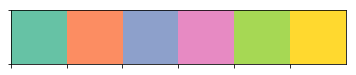

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score,train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm

%matplotlib inline
current_palette_1 = sns.color_palette("Set2", 6)
sns.set_palette(current_palette_1)
sns.palplot(current_palette_1)

# Data Exploration

In [67]:
#import data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [68]:
df_train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 7 columns):
id               371 non-null int64
bone_length      371 non-null float64
rotting_flesh    371 non-null float64
hair_length      371 non-null float64
has_soul         371 non-null float64
color            371 non-null object
type             371 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 20.4+ KB


In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
id               529 non-null int64
bone_length      529 non-null float64
rotting_flesh    529 non-null float64
hair_length      529 non-null float64
has_soul         529 non-null float64
color            529 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 24.9+ KB


In [71]:
#Lets start with summary statistics
df_train.describe(include = "all")

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
count,371.000000,371.000000,371.000000,371.000000,371.000000,371,371
unique,NaN,NaN,NaN,NaN,NaN,6,3
top,NaN,NaN,NaN,NaN,NaN,white,Ghoul
freq,NaN,NaN,NaN,NaN,NaN,137,129
mean,443.676550,0.434160,0.506848,0.529114,0.471392,NaN,NaN
std,263.222489,0.132833,0.146358,0.169902,0.176129,NaN,NaN
min,0.000000,0.061032,0.095687,0.134600,0.009402,NaN,NaN
25%,205.500000,0.340006,0.414812,0.407428,0.348002,NaN,NaN
50%,458.000000,0.434891,0.501552,0.538642,0.466372,NaN,NaN
75%,678.500000,0.517223,0.603977,0.647244,0.600610,NaN,NaN


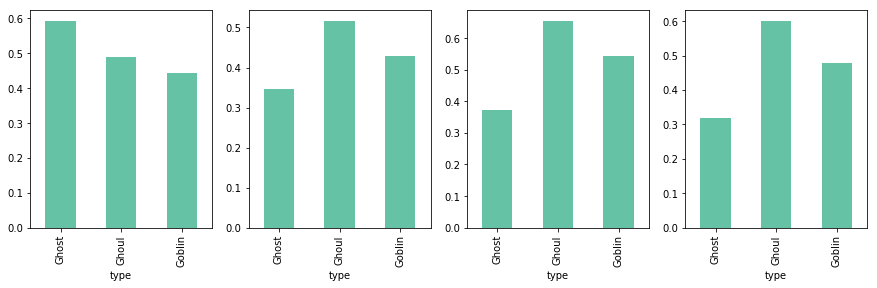

In [72]:
#Lets plot each coloumn with respect to type
plt.subplot(1,4,1)
df_train.groupby('type').mean()['rotting_flesh'].plot(kind='bar',figsize=(15,4))
plt.subplot(1,4,2)
df_train.groupby('type').mean()['bone_length'].plot(kind='bar',figsize=(15,4))
plt.subplot(1,4,3)
df_train.groupby('type').mean()['hair_length'].plot(kind='bar',figsize=(15,4))
plt.subplot(1,4,4)
df_train.groupby('type').mean()['has_soul'].plot(kind='bar',figsize=(15,4))

It seems that all numeric features are useful

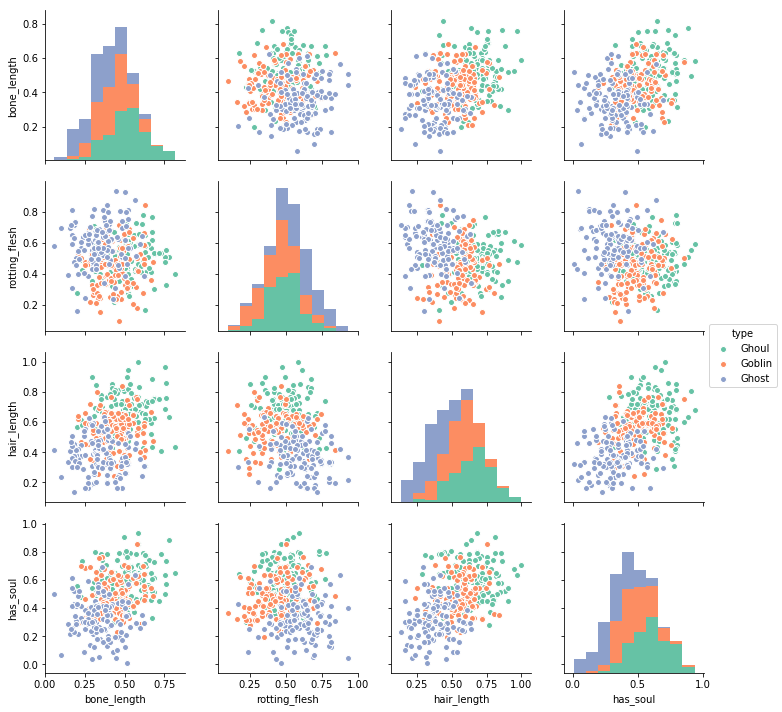

In [73]:
sns.pairplot(hue='type',data=df_train,vars=['bone_length','rotting_flesh','hair_length','has_soul'])

Normally distributed data. Most pairs are widely scattered. Some of them show correlations for eg: hair_length and has_soul, hair_length and bone_length

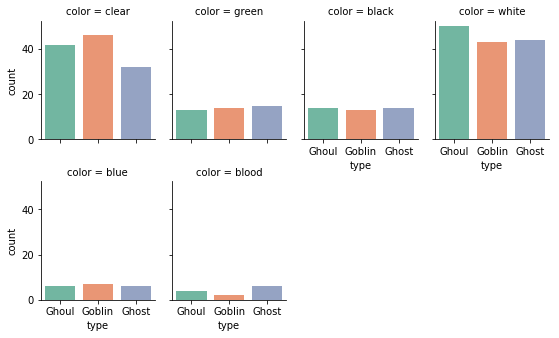

In [74]:
#Lets plot the colors
sns.factorplot(x='type',col='color',col_wrap=4,data=df_train,kind='count',size=2.4,aspect=0.8)


Colors are evenly distributed. They may or may not be important for learning so we won't remove them

# Data Preparation

In [75]:
#Lets multiply coloumns with correlations. This improves performance
df_train['hair_soul'] = df_train['hair_length'] * df_train['has_soul']
df_train['hair_bone'] = df_train['hair_length'] * df_train['bone_length']
df_test['hair_soul'] = df_test['hair_length'] * df_test['has_soul']
df_test['hair_bone'] = df_test['hair_length'] * df_test['bone_length']
df_train['hair_soul_bone'] = df_train['hair_length'] * df_train['has_soul'] * df_train['bone_length']
df_test['hair_soul_bone'] = df_test['hair_length'] * df_test['has_soul'] * df_test['bone_length']

In [76]:
#Dropping id coloumn and saving it for later use
save_id = df_test['id']
df_train.drop(['id'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

In [77]:
#Creating dummy variables
col = 'color'
dummies = pd.get_dummies(df_train[col], drop_first=False)
dummies = dummies.add_prefix("{}_".format(col))
df_train.drop(col, axis=1, inplace=True)
df_train = df_train.join(dummies)
dummies = pd.get_dummies(df_test[col], drop_first=False)
dummies = dummies.add_prefix("{}_".format(col))
df_test.drop(col, axis=1, inplace=True)
df_test = df_test.join(dummies)

In [78]:
X_train = df_train.drop('type',axis=1)
le = LabelEncoder()
Y_train =  le.fit_transform(df_train['type'].values)
X_test = df_test

In [79]:
#Feature Selection
rf_clf = RandomForestClassifier(n_estimators = 15,
                                criterion = 'gini',
                                max_features = 'sqrt',
                                max_depth = None,                                
                                min_samples_split =7,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 18)
rf_clf = rf_clf.fit(X_train, Y_train)

#print coloumns in descending order of their importances
indices = np.argsort(rf_clf.feature_importances_)[::-1]
X_train.columns[indices]

Index(['hair_soul_bone', 'hair_soul', 'hair_length', 'has_soul',
       'rotting_flesh', 'hair_bone', 'bone_length', 'color_blue',
       'color_clear', 'color_black', 'color_white', 'color_green',
       'color_blood'],
      dtype='object')

Including color during learning decreases performance.

In [80]:
selected_features = X_train.columns[indices[0:7]]
X = X_train[selected_features]
Xt = X_test[selected_features]

# Modelling

In [81]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y_train, test_size=0.20, random_state=36)

There is not enough data for random forest. So I will try Logistic Regression and svm

In [88]:
#SVM
svc = svm.SVC(kernel='linear')
svc.fit(Xtrain, ytrain)
# Y_pred = svc.predict(Xtest) 
svc.score(Xtest,ytest)

0.76000000000000001

In [83]:
#Using gridsearch to tune parameters
logreg = LogisticRegression()

parameter_grid = {'solver' : ['newton-cg', 'lbfgs'],
                  'multi_class' : ['ovr', 'multinomial'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005]
                 }

grid_search = GridSearchCV(logreg, param_grid=parameter_grid, cv=StratifiedKFold(5))
grid_search.fit(Xtrain, ytrain)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.75
Best parameters: {'C': 1, 'multi_class': 'multinomial', 'solver': 'newton-cg', 'tol': 0.0001}


In [89]:
#Logistic Regression
log_reg = LogisticRegression(C = 1, tol = 0.0001, solver='newton-cg', multi_class='multinomial')
log_reg.fit(Xtrain, ytrain)
log_reg.score(Xtest,ytest)

0.77333333333333332

Both svm and lr have comparable performances.As far as I understand In this case LR wins out because of it's probabilstic nature whereas svm is more of a hard classifier

In [95]:
#Predicting test set provided by kaggle
Y_pred_log = log_reg.predict(Xt)
#inverting the label encoded values to their original values
Y_pred_log_final = le.inverse_transform(Y_pred_log)

In [96]:
#Creating the submission file
submission = pd.DataFrame({'id':save_id, 'type':Y_pred_log_final})
submission.to_csv('submit.csv', index=False)